In [1]:
import alibi
import matplotlib.pyplot as plt
import numpy as np
import paltas
import tensorflow as tf
from tqdm import tqdm

import bendorbreak as bb

# Should print GPU if tensorflow can use it
print(tf.config.list_physical_devices('GPU'))
model = bb.march2022_paper_model()
param_names, _, _ = bb.parse_norms_csv()

2023-08-18 16:24:44.377233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jaalbers/miniconda3/envs/tfgpu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/mnt/data/software/paltas/paltas/Configs/config_handler.py:320: RuntimeWarning: Parameter (source_parameters, source_exclusion_list) in config_dict, and possibly others, will not be written to metadata.csv
  warnings.warn(


1/1 [==============================] - 3s 3s/step


,prediction,prior_mean,prior_scale,truth,error_sigma
parameter,,,,,
theta_E,1.076477,1.095819,0.154412,1.1,-0.152337
gamma1,-0.002093,0.000700,0.050467,0.0,-0.041475
gamma2,-0.001802,-0.000390,0.048422,0.0,-0.037217
gamma,1.987040,2.002955,0.103719,2.0,-0.124954
e1,-0.004723,0.004104,0.101401,0.0,-0.046578
e2,-0.007323,0.000567,0.098705,0.0,-0.074194
center_x,-0.000496,-0.005954,0.160088,0.0,-0.003100
center_y,0.002496,-0.003617,0.156996,0.0,0.015900
sigma_sub,0.001466,0.001972,0.001084,0.0,1.352488


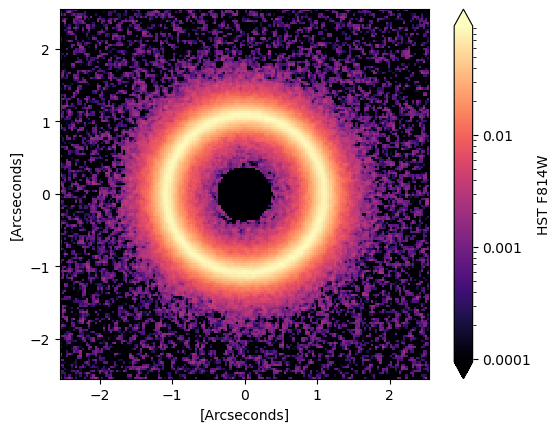

In [2]:
# Optional hack to fix galaxy index
# 4584 is a nice face-on spiral. 47 seems like a boring elliptical
chosen_galaxy = 47
paltas.Sources.cosmos.COSMOSCatalog.sample_indices = lambda *_: np.full(1, chosen_galaxy)

# Create a super sweet lens, perfectly symmetric without substructure
img, metadata = bb.generate_image({
    'theta_E': 1.1,
    'sigma_sub': 0,
    'e1': 0, 
    'e2': 0, 
    'gamma': 2,
    'gamma1': 0,
    'gamma2': 0, 
    'center_x': 0,
    'center_y': 0,
    'source/parameters/center_x': 0,
    'source/parameters/center_y': 0,
    'delta_los': 0,
})
bb.plot_image(img)
bb.single_image_test(model, img, truth=metadata)

100%|██████████| 5/5 [01:02<00:00, 12.59s/it]


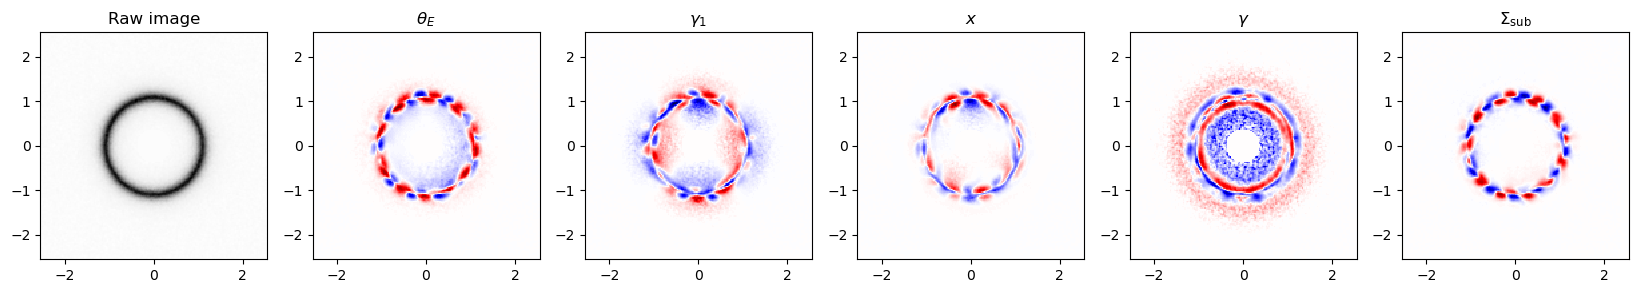

In [3]:
# Which parameters to draw saliency maps for.
#attr_params = param_names  
attr_params = ('theta_E', 'gamma1', 'center_x', 'gamma', 'sigma_sub')
# Average over rotated images fed to the network
# (labels & maps properly rotated back before averaging)
n_rotations = 16

# Subplot with two panels
n_params = len(attr_params)
fig, axes = plt.subplots(
    1, n_params + 1, figsize=(3 + 3.5 * n_params, 3))

plt.sca(axes[0])
bb.plot_image(img, log_scale=False, cmap=plt.cm.Greys, colorbar=False)
plt.title("Raw image")

for param, ax in tqdm(zip(attr_params, axes[1:]), total=n_params):
    plt.sca(ax)
    z = bb.integrated_gradients_map(img, model, param, n_rotations=n_rotations)
    zmax = max(-z.min(), z.max())

    bb.plot_image(
        z, 
        log_scale=False,
        label='',
        vmin=-zmax, vmax=zmax,
        colorbar=False,
        cmap=plt.cm.seismic)
    plt.title(bb.parameter_labels[param])

for ax in axes:
    plt.sca(ax)
    plt.xlabel("")
    plt.ylabel("")
plt.savefig(f'integrated_gradients_example_{chosen_galaxy}.png', dpi=300, bbox_inches='tight')
plt.show()

Alibi also has a built-in overlay plot you could use:

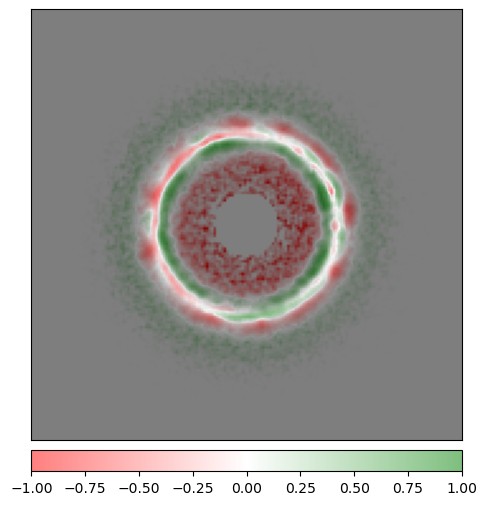

(<Figure size 600x600 with 2 Axes>, <AxesSubplot: >)

In [4]:
z = bb.integrated_gradients_map(img, model, 'gamma', n_rotations=16)
alibi.utils.visualize_image_attr(
    attr=z[...,None],
    original_image=img[...,None],
    method='blended_heat_map',
    sign='all',
    show_colorbar=True)